In [11]:
import sys
print(sys.executable)


C:\Users\pavit\miniconda3\python.exe


In [12]:
import sys
print("Using Python:", sys.executable)

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip uninstall -y spacy
!{sys.executable} -m pip install --upgrade spacy


Using Python: C:\Users\pavit\miniconda3\python.exe
  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.1
    Uninstalling pip-25.1:
      Successfully uninstalled pip-25.1
Found existing installation: spacy 3.8.11
Uninstalling spacy-3.8.11:
  Successfully uninstalled spacy-3.8.11
  Using cached spacy-3.8.11-cp313-cp313-win_amd64.whl.metadata (28 kB)
Using cached spacy-3.8.11-cp313-cp313-win_amd64.whl (14.2 MB)


In [13]:
!{sys.executable} -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 324.4 k

In [14]:
import sys
print("Python:", sys.executable)

import spacy
nlp = spacy.load("en_core_web_sm")
print("spaCy model loaded, pipeline components:", nlp.pipe_names)


Python: C:\Users\pavit\miniconda3\python.exe
spaCy model loaded, pipeline components: ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [17]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")
fake_path = "Fake.csv"
true_path = "True.csv"

df_fake = pd.read_csv(fake_path)
df_true = pd.read_csv(true_path)

df_fake['label'] = 0
df_true['label'] = 1

def make_text(df):
    if 'title' in df.columns and 'text' in df.columns:
        return (df['title'].fillna('') + ' ' + df['text'].fillna('')).str.strip()
    elif 'text' in df.columns:
        return df['text'].astype(str)
    else:
        return df.astype(str).agg(' '.join, axis=1)

df_fake['text'] = make_text(df_fake)
df_true['text'] = make_text(df_true)

df = pd.concat([df_fake[['text','label']], df_true[['text','label']]], ignore_index=True)

print(df.shape)
df.head()


(44898, 2)


text  label
0  Donald Trump Sends Out Embarrassing New Year’s...      0
1  Drunk Bragging Trump Staffer Started Russian C...      0
2  Sheriff David Clarke Becomes An Internet Joke ...      0
3  Trump Is So Obsessed He Even Has Obama’s Name ...      0
4  Pope Francis Just Called Out Donald Trump Duri...      0

In [20]:
df.columns

Index(['text', 'label'], dtype='object')

In [21]:
import re
def clean_text_simple(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text) 
    text = re.sub(r'<.*?>', ' ', text)                  
    text = re.sub(r'[^a-z0-9\s]', ' ', text)             
    text = re.sub(r'\s+', ' ', text).strip()             
    return text

df['clean'] = df['text'].apply(clean_text_simple)

print("Created df['clean']. Sample:")
display(df[['text','clean']].head(3))
print("\nColumns now:", df.columns.tolist())
print("Number of rows:", len(df))


Created df['clean']. Sample:


text  \
0  Donald Trump Sends Out Embarrassing New Year’s...   
1  Drunk Bragging Trump Staffer Started Russian C...   
2  Sheriff David Clarke Becomes An Internet Joke ...   

                                               clean  
0  donald trump sends out embarrassing new year s...  
1  drunk bragging trump staffer started russian c...  
2  sheriff david clarke becomes an internet joke ...


Columns now: ['text', 'label', 'clean']
Number of rows: 44898


In [22]:
from sklearn.model_selection import train_test_split

X = df['clean'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.12, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 39510 Test size: 5388


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

tfidf = TfidfVectorizer(stop_words='english', max_features=25000, ngram_range=(1,2), min_df=5, sublinear_tf=True)
clf = LinearSVC(C=1.0, class_weight='balanced', max_iter=10000, random_state=42)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

print("Pipeline ready.")


Pipeline ready.


In [24]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Running 5-fold CV (f1)... this may take a few minutes depending on CPU).")

f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
print("F1 scores:", np.round(f1_scores, 4))
print("Mean F1: {:.4f} ± {:.4f}".format(f1_scores.mean(), f1_scores.std()))


Running 5-fold CV (f1)... this may take a few minutes depending on CPU).
F1 scores: [0.9977 0.9966 0.9972 0.9972 0.9977]
Mean F1: 0.9973 ± 0.0004


In [25]:
print("Fitting pipeline on full training set...")
pipeline.fit(X_train, y_train)

print("Predicting on test set...")
y_pred = pipeline.predict(X_test)

Fitting pipeline on full training set...
Predicting on test set...


Classification report (test):
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      2818
        real       1.00      1.00      1.00      2570

    accuracy                           1.00      5388
   macro avg       1.00      1.00      1.00      5388
weighted avg       1.00      1.00      1.00      5388



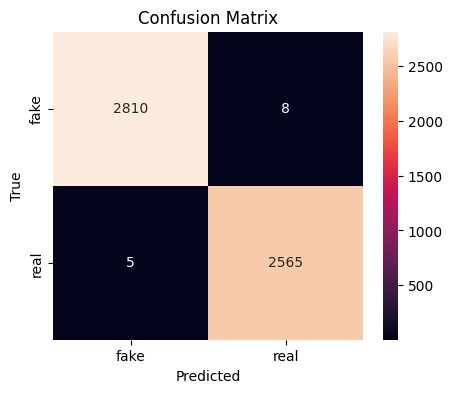

ROC AUC (test): 1.0000


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

print("Classification report (test):")
print(classification_report(y_test, y_pred, target_names=['fake','real']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['fake','real'], yticklabels=['fake','real'])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

try:
    scores = pipeline.decision_function(X_test)
    auc = roc_auc_score(y_test, scores)
    print("ROC AUC (test): {:.4f}".format(auc))
    fpr, tpr, _ = roc_curve(y_test, scores)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
    plt.show()
except Exception as e:
    print("Could not compute ROC AUC:", e)


In [27]:
import pandas as pd
res = pd.DataFrame({'text': X_test, 'true': y_test, 'pred': y_pred})
false_neg = res[(res['true']==1) & (res['pred']==0)]
false_pos = res[(res['true']==0) & (res['pred']==1)]

print("False negatives (real->fake):", len(false_neg))
print("False positives (fake->real):", len(false_pos))

for i, row in false_neg.sample(min(3, len(false_neg)), random_state=42).iterrows():
    print("---- REAL but predicted FAKE ----")
    print(row['text'][:800])
    print()

for i, row in false_pos.sample(min(3, len(false_pos)), random_state=42).iterrows():
    print("---- FAKE but predicted REAL ----")
    print(row['text'][:800])
    print()


False negatives (real->fake): 5
False positives (fake->real): 8
---- REAL but predicted FAKE ----
live from new york it s a trump clinton rematch of sorts new york reuters veteran actor and frequent host alec baldwin returned to saturday night live on saturday debuting his new gig playing a scowling blustering donald trump the republican nominee for u s president the late night nbc comedy show kicking off its 42nd season opened with an extended sketch featuring baldwin as trump facing off with a calculating cunning and smug hillary clinton with kate mckinnon reprising her turn as the democratic nominee much of the routine was lifted from the opponents monday debate including references to talk show host and trump nemesis rosie o donnell and vocal trump backer fox news sean hannity baldwin began his trump routine promising i m going to be so good tonight before issuing a perfunctory res

---- REAL but predicted FAKE ----
obama statement on death of supreme court justice scalia rancho mi

In [28]:
import joblib
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)
model_path = MODEL_DIR / "tfidf_linear_svc_simple.joblib"
joblib.dump(pipeline, model_path)
print("Saved pipeline to", model_path)


Saved pipeline to models\tfidf_linear_svc_simple.joblib


In [29]:
import joblib
model = joblib.load("models/tfidf_linear_svc_simple.joblib")

examples = [
    "Breaking: New study shows chocolate helps you live longer.",
    "Government passes new law to improve public healthcare funding."
]

# apply same simple cleaning used earlier
import re
def clean_text_simple(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

examples_clean = [clean_text_simple(t) for t in examples]
X_ex = model.named_steps['tfidf'].transform(examples_clean)
preds = model.named_steps['clf'].predict(X_ex)

for t, p in zip(examples, preds):
    print("Text:", t)
    print("Predicted:", "real" if p==1 else "fake")
    print("-----")


Text: Breaking: New study shows chocolate helps you live longer.
Predicted: fake
-----
Text: Government passes new law to improve public healthcare funding.
Predicted: real
-----
